# Dados Desbalanceados

In [ ]:
import pandas as pd

df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


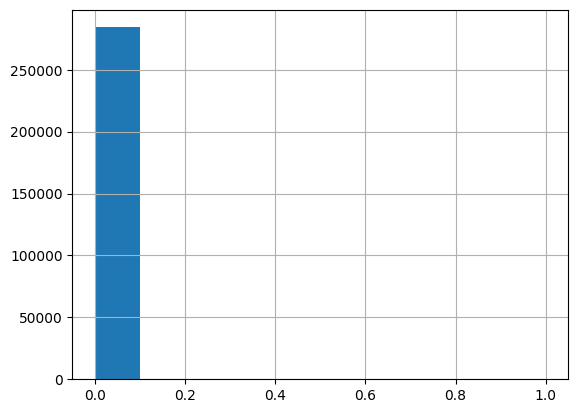

In [ ]:
g = df['Class'].hist()

In [ ]:
import numpy as np
c0, c1 = np.bincount(df['Class'])
c0, c1

(284315, 492)

In [ ]:
fator = c1/c0
fator * 100.

0.17304750013189596

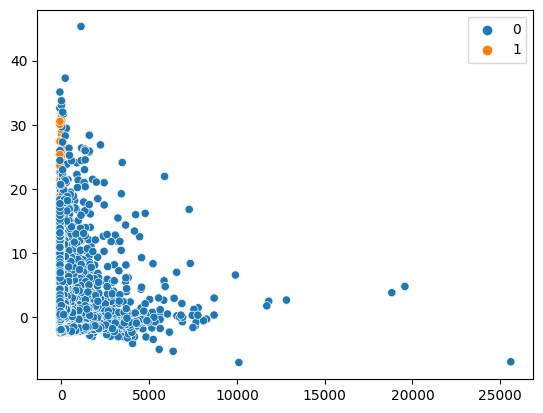

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

X = df[df.columns[1:-1]].values
y = df[df.columns[-1]].values

pca = PCA(n_components=2,random_state=42)
Xpca = pca.fit_transform(X)
g = sns.scatterplot(x=Xpca[:,0],y=Xpca[:,1],hue=y)

## SMOTE

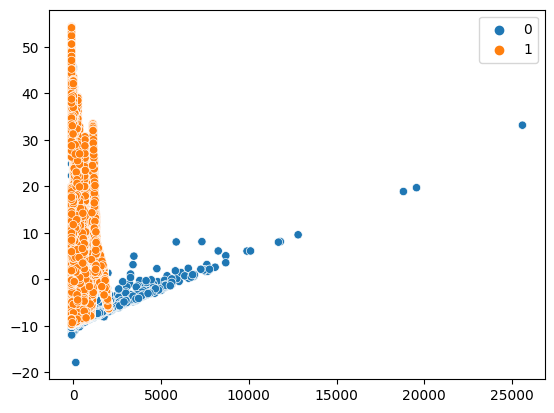

In [ ]:
from imblearn.over_sampling import SMOTE

X = df[df.columns[1:-1]].values
y = df[df.columns[-1]].values

oversample = SMOTE()
Xb, yb = oversample.fit_resample(X, y)

Xpca = pca.fit_transform(Xb)
g = sns.scatterplot(x=Xpca[:,0],y=Xpca[:,1],hue=yb)

# Problema do Desaparecimento de Gradiente

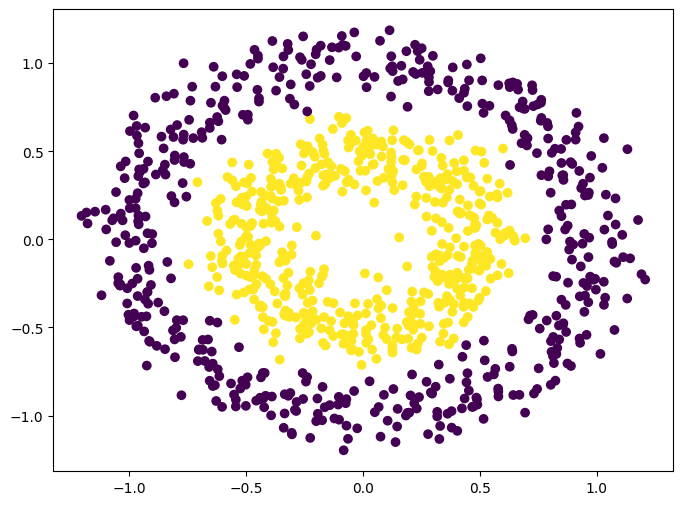

In [ ]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
 
# Make data: Two circles on x-y plane as a classification problem
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)
 
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
 
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "relu"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=32, epochs=100, verbose=0)
print(model.evaluate(X,y))

32/32 [==============================] - 0s 3ms/step - loss: 0.3294 - acc: 0.9290
[0.32941433787345886, 0.9290000200271606]


In [ ]:
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "sigmoid"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=32, epochs=100, verbose=0)
print(model.evaluate(X,y))

32/32 [==============================] - 0s 2ms/step - loss: 0.6923 - acc: 0.5250
[0.6922534108161926, 0.5249999761581421]


In [ ]:
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "sigmoid"),
    Dense(5, "sigmoid"),
    Dense(5, "sigmoid"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=32, epochs=100, verbose=0)
print(model.evaluate(X,y))

32/32 [==============================] - 0s 2ms/step - loss: 0.6793 - acc: 0.5830
[0.6793376803398132, 0.5830000042915344]


## Visualizando os Pesos Sinápticos

32/32 [==============================] - 0s 2ms/step - loss: 0.6169 - acc: 0.6210
[0.6168842315673828, 0.6209999918937683]


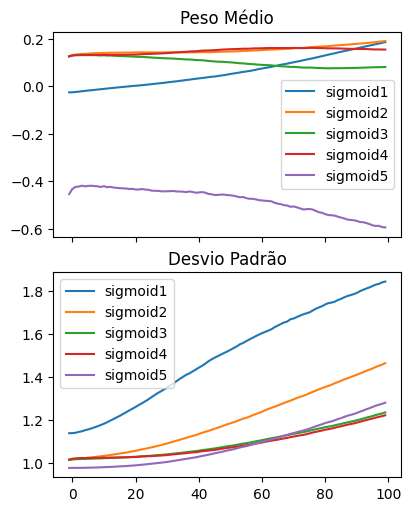

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.initializers import RandomNormal
 
class WeightCapture(Callback):
    "Capture the weights of each layer of the model"
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []
 
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) # remember the epoch axis
        weight = {}
        for layer in model.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)

def plotweight(capture_cb):
    "Plot the weights' mean and s.d. across epochs"
    fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(4, 5))
    ax[0].set_title("Peso Médio")
    for key in capture_cb.weights[0]:
        ax[0].plot(capture_cb.epochs, [w[key].mean() for w in capture_cb.weights], label=key)
    ax[0].legend()
    ax[1].set_title("Desvio Padrão")
    for key in capture_cb.weights[0]:
        ax[1].plot(capture_cb.epochs, [w[key].std() for w in capture_cb.weights], label=key)
    ax[1].legend()
    plt.show()

def make_mlp(activation, initializer, name):
    "Create a model with specified activation and initalizer"
    model = Sequential([
        Input(shape=(2,), name=name+"0"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"1"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"2"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"3"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"4"),
        Dense(1, activation="sigmoid", kernel_initializer=initializer, name=name+"5")
    ])
    return model

initializer = RandomNormal(mean=0.0, stddev=1.0, seed=42)
batch_size = 32
n_epochs = 100
 
model = make_mlp("sigmoid", initializer, "sigmoid")
capture_cb = WeightCapture(model)
capture_cb.on_epoch_end(-1)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
hist = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[capture_cb], verbose=0)
print(model.evaluate(X,y))
plotweight(capture_cb)

32/32 [==============================] - 0s 2ms/step - loss: 0.0109 - acc: 0.9950
[0.010945265181362629, 0.9950000047683716]


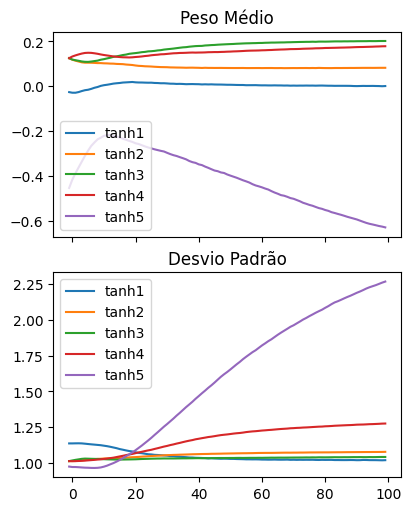

In [ ]:
# tanh activation, large variance gaussian initialization
model = make_mlp("tanh", initializer, "tanh")
capture_cb = WeightCapture(model)
capture_cb.on_epoch_end(-1)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[capture_cb], verbose=0)
print(model.evaluate(X,y))
plotweight(capture_cb)

32/32 [==============================] - 0s 2ms/step - loss: 0.0111 - acc: 0.9970
[0.011146385222673416, 0.996999979019165]


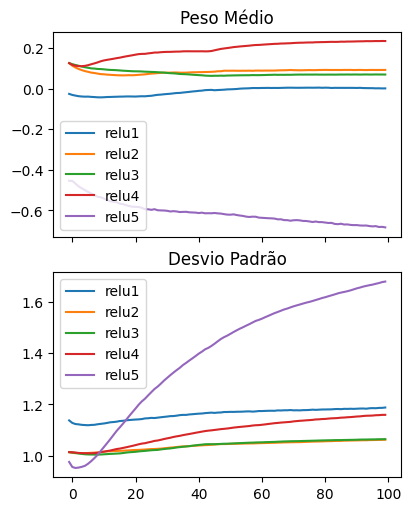

In [ ]:
# relu activation, large variance gaussian initialization
model = make_mlp("relu", initializer, "relu")
capture_cb = WeightCapture(model)
capture_cb.on_epoch_end(-1)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[capture_cb], verbose=0)
print(model.evaluate(X,y))
plotweight(capture_cb)

# Problema do Gradiente Explosivo

Train: nan, Test: nan


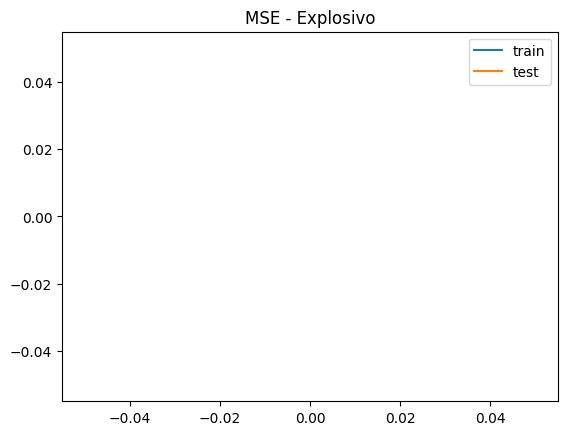

In [ ]:
# mlp with unscaled data for the regression problem
from sklearn.datasets import make_regression
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot

# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=opt)
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
# evaluate the model
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.title('MSE - Explosivo')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train: 0.357, Test: 11.203


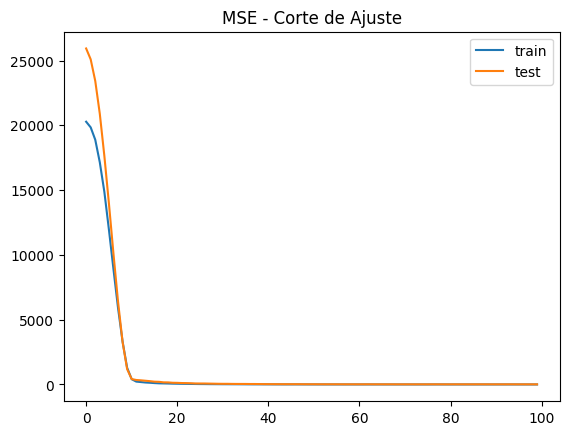

In [ ]:
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt)
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
# evaluate the model
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.title('MSE - Corte de Ajuste')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Sobretreinamento e Subtreinamento

In [ ]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-o3i6vn26
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-o3i6vn26
  Resolved https://github.com/tensorflow/docs to commit 99113f26039f6c042df7f2898e05019dbcdf3675
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=182618 sha256=6517b83d3ea0de74e751c28cf78cf74717b914500c23919cbb46e5af8429398e
  Stored in directory: /tmp/pip-ephem-wheel-cache-f6pnl3hg/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

print(tf.__version__)

2.12.0


In [ ]:
# física de partículas, contém 11.000.000 exemplos, cada um com 28 recursos e um rótulo de classe binária.
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 48s 0us/step


tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


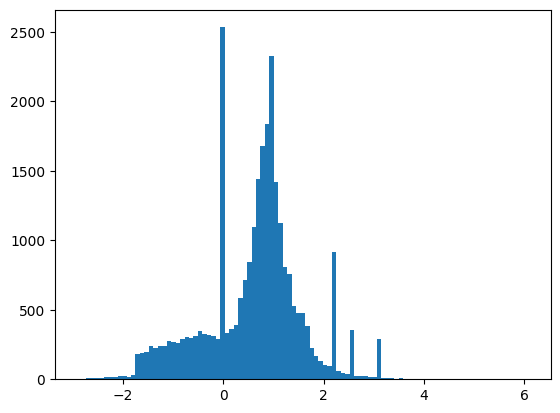

In [ ]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

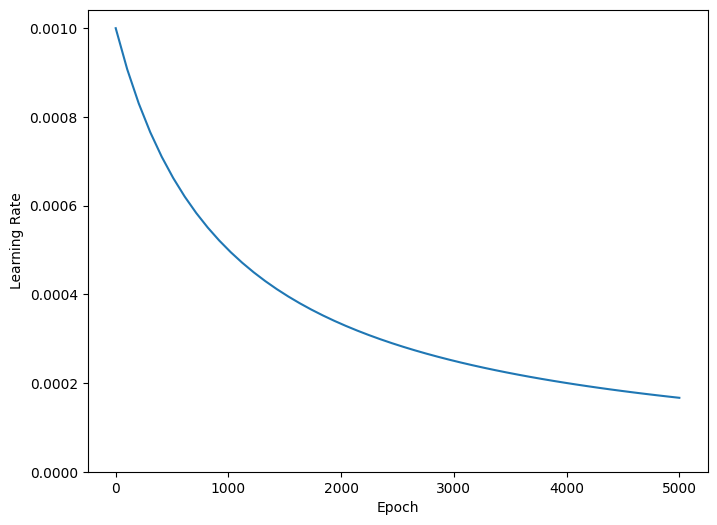

In [ ]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False,
  )

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                464       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4793,  binary_crossentropy:0.7566,  loss:0.7566,  val_accuracy:0.4540,  val_binary_crossentropy:0.7289,  val_loss:0.7289,  
....................................................................................................
Epoch: 100, accuracy:0.5931,  binary_crossentropy:0.6279,  loss:0.6279,  val_accuracy:0.5710,  val_binary_crossentropy:0.6346,  val_loss:0.6346,  
..........................................................

(0.5, 0.7)

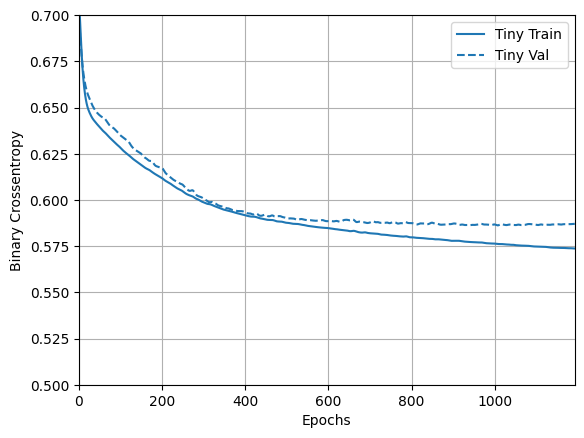

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [ ]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                464       
                                                                 
 dense_15 (Dense)            (None, 16)                272       
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4905,  binary_crossentropy:0.7960,  loss:0.7960,  val_accuracy:0.4630,  val_binary_crossentropy:0.7531,  val_loss:0.7531,  
....................................................................................................
Epoch: 100, accuracy:0.6260,  binary_crossentropy:0.6141,  loss:0.6141,  

In [ ]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 64)                1856      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4844,  binary_crossentropy:0.7093,  loss:0.7093,  val_accuracy:0.5020,  val_binary_crossentropy:0.6823,  val_loss:0.6823,  
...................................

In [ ]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               14848     
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dense_24 (Dense)            (None, 512)               262656    
                                                                 
 dense_25 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5149,  binary_crossentrop

Text(0.5, 0, 'Epochs [Log Scale]')

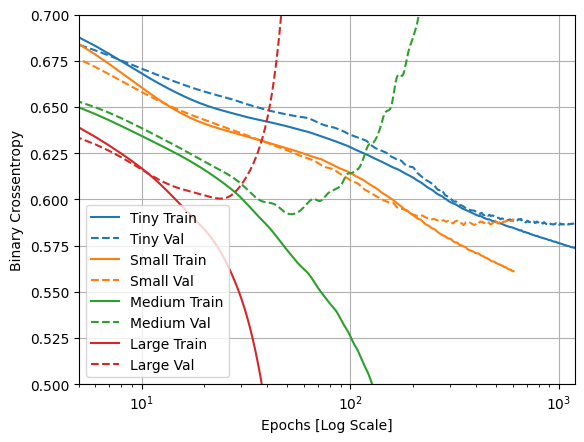

In [ ]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")